**Importing packages**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from tqdm import tqdm
from os import listdir, makedirs
from os.path import join

**Checking GPU is available**

In [ ]:

if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 16  # Number of images used in each iteration
    EPOCHS = 3  # Number of passes through entire dataset


else:
    # CPU
    BATCH_SIZE = 4
    EPOCHS = 1

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


**Functions to perform train and test**

In [ ]:
import numpy as np
import requests

from os.path import join
import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array,array_to_img, load_img
from keras.applications import xception
from tensorflow.keras.utils import load_img
from mpl_toolkits.axes_grid1 import ImageGrid
# from keras.preprocessing import image
from tensorflow.keras.utils import load_img
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def split_train_val(labels, num_classes, seed=1234):
    selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)
    labels = labels.loc[labels['breed'].isin(selected_breed_list)].reset_index()
    labels['target'] = 1
    labels['rank'] = labels.groupby('breed').rank()['id']
    labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
    np.random.seed(seed=seed)
    rnd = np.random.random(len(labels))
    train_idx = rnd < 0.8
    valid_idx = rnd >= 0.8
    y_train = labels_pivot[selected_breed_list].values
    ytr = y_train[train_idx]
    yv = y_train[valid_idx]
    return (train_idx, valid_idx, ytr, yv, labels, selected_breed_list)


def read_img(img_id, data_dir, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = img_to_array(img)
    return img


def show_images(num_classes, labels, data_dir):
    j = int(np.sqrt(num_classes))
    i = int(np.ceil(1. * num_classes / j))
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
    for i, (img_id, breed) in enumerate(labels.loc[labels['rank'] == 2, ['id', 'breed']].values):
        ax = grid[i]
        img = read_img(img_id, data_dir, 'train', (224, 224))
        ax.imshow(img / 255.)
        ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
        ax.axis('off')
    plt.show()

def data_augmentation_example(input_path, count):
    # load image to array
    image = img_to_array(load_img(input_path))

    # reshape to array rank 4
    image = image.reshape((1,) + image.shape)

    # let's create infinite flow of images
    train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
    images_flow = train_datagen.flow(image, batch_size=1)

    plt.figure(figsize=(9,9))
    for idx, new_images in enumerate(images_flow):
        if idx < count:
            plt.subplot(330 + 1 + idx)
            new_image = array_to_img(new_images[0], scale=True)
            plt.imshow(new_image)
            plt.axis('off')
        else:
            plt.show()
            break





def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

**Collecting data from kaggle**

In [ ]:
import gc
gc.collect()
from google.colab import files
files.upload()
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

#download the dataset for the dog-breed identification challenge https://www.kaggle.com/c/dog-breed-identification
!kaggle competitions download -c dog-breed-identification

#unzip the downloaded files
from zipfile import ZipFile
zip_files = ["dog-breed-identification.zip"]
for files in zip_files:
    with ZipFile(files, "r") as zips:
        zips.extractall()
print("All Files Extracted")

**Visualizing the dataset**

In [ ]:
NUM_CLASSES = 80

data_dir = '/content/' # ADD path/to/dataset
labels = pd.read_csv(join(data_dir, 'labels.csv')) # EDIT WITH YOUR LABELS FILE NAME
print("Total number of images in the dataset: {}".format(len(listdir(join(data_dir, 'train')))))

print("Top {} labels (sorted by number of samples)".format(NUM_CLASSES))
(labels
 .groupby("breed")
 .count()
 .sort_values("id", ascending=False)
 .head(NUM_CLASSES)
)


input_path = '/content/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg' # An example image from the dataset
count = 9 # Number of samples to show

data_augmentation_example(input_path, count)
# Make sure to have the same split
SEED = 2018

(train_idx, valid_idx, ytr, yv, labels, selected_breed_list) = split_train_val(labels, NUM_CLASSES, seed=SEED)
from tensorflow.keras.utils import load_img
# from tensorflow.keras.utils import image


show_images(NUM_CLASSES, labels, data_dir)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from keras.applications import xception
import PIL
widths, heights = [], []
width_min, width_max = np.inf, -np.inf
height_min, height_max = np.inf, -np.inf
train_path='/content/train'
for filename in os.listdir(train_path):
  if 'jpg'  in filename:
      # print(filename)
      image = PIL.Image.open(os.path.join(train_path, filename))

      # Append image dimensions to list.
      widths.append(image.size[0])  # width
      heights.append(image.size[1])  # height

INPUT_SIZE = 299 # width/height of image in pixels (as expected by Xception model)

x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, data_dir, 'train', (INPUT_SIZE, INPUT_SIZE))
    # widths.append(img.size[0])  # width
    # heights.append(img.size[1])  # height
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('\nTotal Images shape: {}'.format(x_train.shape))

Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print('Train (images, H, W, C):', Xtr.shape,
      '\nVal (images, H, W, C):', Xv.shape,
      '\n\nTrain samples (images, labels)', ytr.shape,
      '\nValidation samples (images, labels)', yv.shape)


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator()

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Histograms of training image widths, heights')

ax1.hist(widths, bins=100); ax1.set_xlabel('Width'); ax1.set_ylabel('No. of images')
ax2.hist(heights, bins=100); ax2.set_xlabel('Height'); ax2.set_ylabel('No. of images')

plt.show()

#constants
num_classes = 120 # the number of breeds we want to classify
seed = 42 # makes the random numbers in numpy predictable
im_size = 299 # This size of the images
batch_size = 32

#Read the csv into a dataframe, group the breeds and
df = pd.read_csv('labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)
df = df[df['breed'].isin(selected_breed_list)]
df['filename'] = df.apply(lambda x: ('train/' + x['id'] + '.jpg'), axis=1)


breeds = pd.Series(df['breed'])
print("total number of breeds to classify",len(breeds.unique()))

df.head()
# data_trained, data_for_test = train_test_split(df,test_size=0.3,random_state= 1234)
hist = df['breed'].hist(figsize=(16, 8), bins=120, xrot=90, xlabelsize=8)
plt.show()
display(df.head(10))

10185it [00:28, 263.82it/s]

**Evaluating some algorithms**

In [ ]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model

# Download and create the pre-trained Xception model for transfer learning
base_model = xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(lr=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                         

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 n)                             256)                                                              
                                                                                                  
 block3_sepconv2 (SeparableConv  (None, None, None,   67840      ['block3_sepconv2_act[0][0]']    
 2D)                            256)                                                              
                                                                                                  
 block3_sepconv2_bn (BatchNorma  (None, None, None,   1024       ['block3_sepconv2[0][0]']        
 lization)                      256)                                                              
                                                                                                  
 conv2d_9 (Conv2D)              (None, None, None,   32768       ['add_24[0][0]']                 
                                256)                                                              
          

AttributeError: ignored

In [ ]:
hist = model.fit_generator(train_datagen.flow(Xtr, ytr, batch_size=BATCH_SIZE),
                           steps_per_epoch=train_idx.sum() // BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=test_datagen.flow(Xv, yv, batch_size=BATCH_SIZE),
                           validation_steps=valid_idx.sum() // BATCH_SIZE,
                           verbose=2)

<ipython-input-8-2fa1fdd90725>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_datagen.flow(Xtr, ytr, batch_size=BATCH_SIZE),


Epoch 1/3


KeyboardInterrupt: ignored

In [ ]:
test_gen = test_datagen.flow(Xv, yv, batch_size=BATCH_SIZE, shuffle=False)
probabilities = model.predict_generator(test_gen)

<ipython-input-43-84d5325eacb4>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  probabilities = model.predict_generator(test_gen)


                      precision    recall  f1-score   support

  scottish_deerhound       0.85      0.88      0.86        25
         maltese_dog       0.92      0.97      0.94        34
        afghan_hound       1.00      0.96      0.98        23
         entlebucher       1.00      1.00      1.00        17
bernese_mountain_dog       1.00      1.00      1.00        23
            shih-tzu       0.92      0.96      0.94        23
      great_pyrenees       1.00      1.00      1.00        25
          pomeranian       1.00      1.00      1.00        21
             basenji       1.00      1.00      1.00        18
             samoyed       1.00      1.00      1.00        25
            airedale       1.00      1.00      1.00        19
     tibetan_terrier       0.94      0.94      0.94        17
            leonberg       1.00      1.00      1.00        26
               cairn       0.95      0.91      0.93        23
              beagle       1.00      1.00      1.00        23
    jap

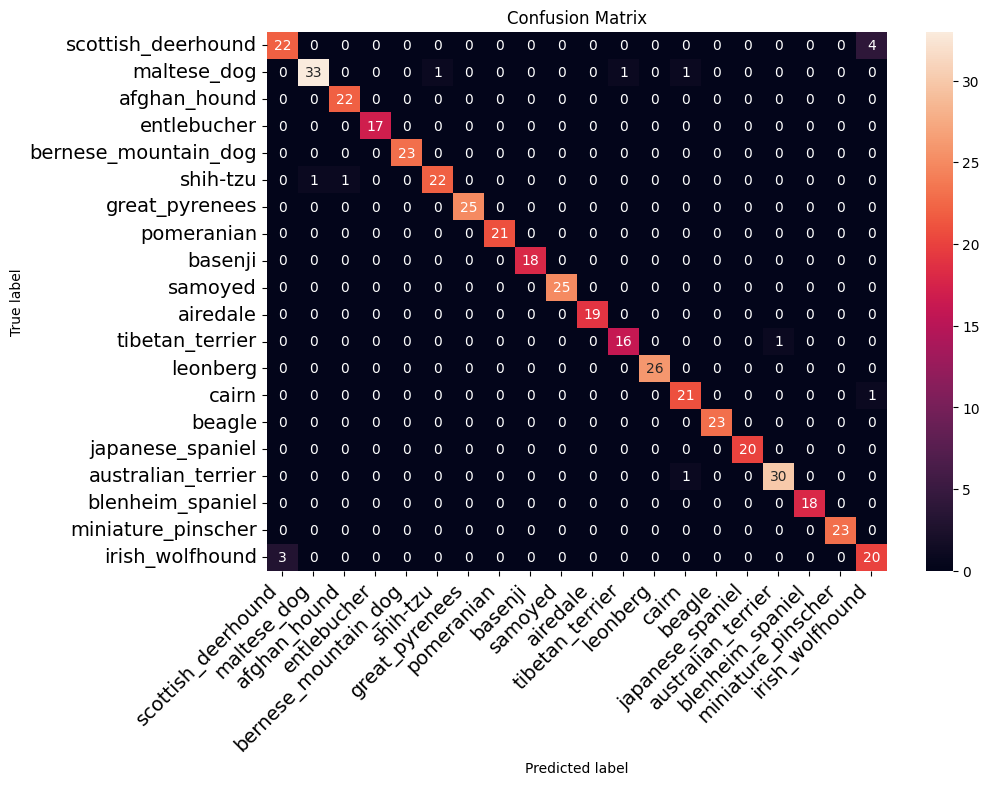

In [ ]:
from sklearn.metrics import confusion_matrix


cnf_matrix = confusion_matrix(np.argmax(yv, axis=1), np.argmax(probabilities,axis=1))
_ = print_confusion_matrix(cnf_matrix, selected_breed_list)
from sklearn.metrics import classification_report

report = classification_report(np.argmax(probabilities,axis=1), np.argmax(yv, axis=1), target_names=selected_breed_list)
print(report)
model.save('test33.h5')